Part 1: Data Merge and Exploratory Data Analysis

1. Loading customer datasets
2. Exploratory Data Analysis (EDA) with visualizations
3. Data cleaning and preprocessing
4. Merging datasets with validation

1: SETUP AND IMPORTS

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from scipy import stats

In [2]:
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

2: LOAD DATASETS

In [4]:
def install_required_packages():
    """Install required packages if missing"""
    try:
        import openpyxl
    except ImportError:
        print("Installing required package: openpyxl")
        os.system(f"{sys.executable} -m pip install openpyxl")
        print("Package installed successfully!")

# Install packages if needed
install_required_packages()

# Create dataset folder if it doesn't exist
if not os.path.exists('dataset'):
    os.makedirs('dataset')
    print("Created 'dataset' folder")

# Load the datasets
print("LOADING DATASETS")
try:
    transactions_df = pd.read_excel('dataset/customer_transactions.xlsx')
    social_profiles_df = pd.read_excel('dataset/customer_social_profiles.xlsx')
    
    print(f"Transactions dataset loaded: {transactions_df.shape}")
    print(f"Social profiles dataset loaded: {social_profiles_df.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure both files are in the 'dataset' folder")


LOADING DATASETS
Transactions dataset loaded: (150, 6)
Social profiles dataset loaded: (155, 5)


3: EXPLORATORY DATA ANALYSIS (EDA)

In [5]:
print("EXPLORATORY DATA ANALYSIS - TRANSACTIONS DATASET")
# 3.1: Basic Information 
print(" Dataset Overview ")
print(f"Shape: {transactions_df.shape}")
print(f"\nColumn Names and Types:")
print(transactions_df.dtypes)

print(" First 5 Rows ")
print(transactions_df.head())

#  3.2: Summary Statistics 
print("Summary Statistics for Numerical Variables")
print(transactions_df.describe())

# Identify variable types
print("Variable Type Classification")
numerical_cols = transactions_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = transactions_df.select_dtypes(include=['object']).columns.tolist()
date_cols = [col for col in transactions_df.columns if 'date' in col.lower()]

print(f"Numerical variables ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical variables ({len(categorical_cols)}): {categorical_cols}")
print(f"Date variables ({len(date_cols)}): {date_cols}")

# 3.3: Missing Values Analysis 
print(" Missing Values ")
missing_data = transactions_df.isnull().sum()
missing_percent = (missing_data / len(transactions_df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Percentage': missing_percent
})
print(missing_df[missing_df['Missing_Count'] > 0])

EXPLORATORY DATA ANALYSIS - TRANSACTIONS DATASET
 Dataset Overview 
Shape: (150, 6)

Column Names and Types:
customer_id_legacy             int64
transaction_id                 int64
purchase_amount                int64
purchase_date         datetime64[ns]
product_category              object
customer_rating              float64
dtype: object
 First 5 Rows 
   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 151            1001              408    2024-01-01   
1                 192            1002              332    2024-01-02   
2                 114            1003              442    2024-01-03   
3                 171            1004              256    2024-01-04   
4                 160            1005               64    2024-01-05   

  product_category  customer_rating  
0           Sports              2.3  
1      Electronics              4.2  
2      Electronics              2.1  
3         Clothing              2.8  
4         Clothin

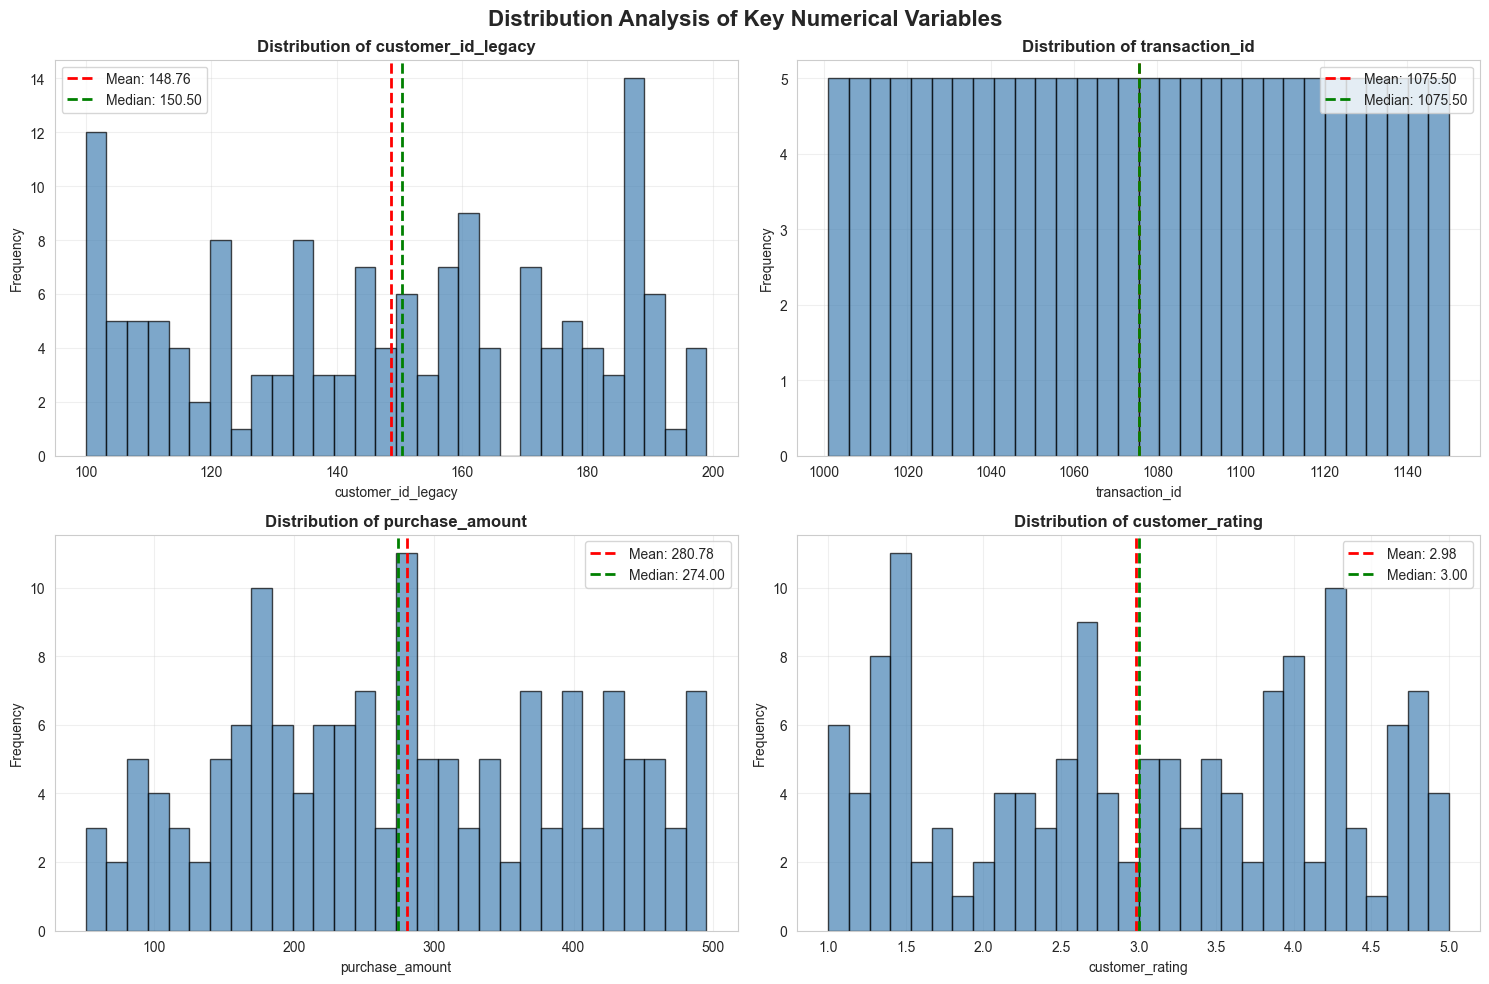

INTERPRETATION:
- The distributions show the spread and central tendency of key numerical features
- We can identify skewness and potential outliers from these histograms
- Mean vs Median comparison helps detect skewed distributions


In [6]:
# PLOT 1: DISTRIBUTION OF NUMERICAL VARIABLES
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution Analysis of Key Numerical Variables', fontsize=16, fontweight='bold')

# Plot distributions for key numerical columns
num_cols_to_plot = numerical_cols[:4]  # Plot first 4 numerical columns

for idx, col in enumerate(num_cols_to_plot):
    row = idx // 2
    col_idx = idx % 2
    ax = axes[row, col_idx]
    
    # Histogram with KDE
    transactions_df[col].hist(bins=30, ax=ax, alpha=0.7, color='steelblue', edgecolor='black')
    ax.set_title(f'Distribution of {col}', fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = transactions_df[col].mean()
    median_val = transactions_df[col].median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    ax.legend()

plt.tight_layout()
plt.savefig('dataset/dataset_visualizations/plot1_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("INTERPRETATION:")
print("- The distributions show the spread and central tendency of key numerical features")
print("- We can identify skewness and potential outliers from these histograms")
print("- Mean vs Median comparison helps detect skewed distributions")

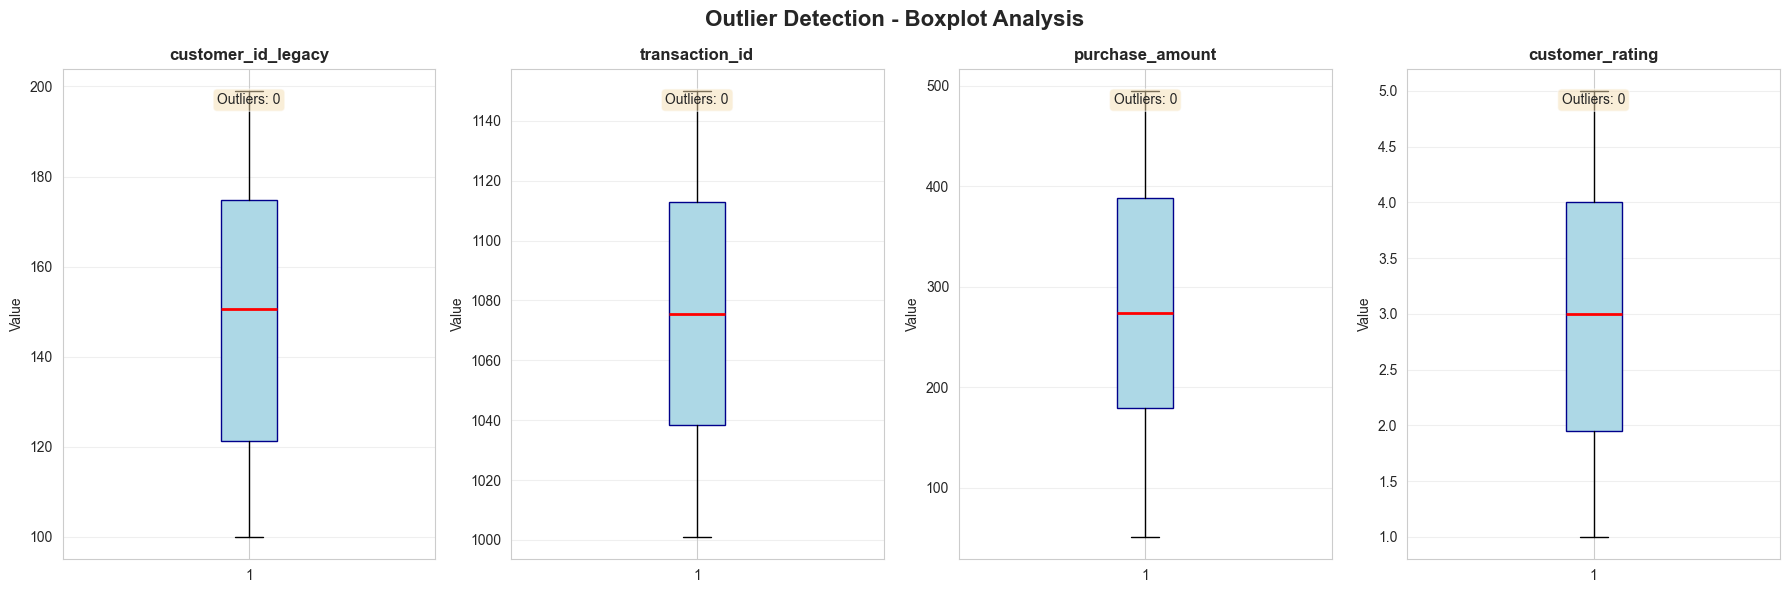

INTERPRETATION:
- Boxplots reveal outliers (points beyond whiskers)
- Outliers may represent data entry errors or legitimate extreme values
- These need to be handled appropriately during data cleaning


In [7]:
# PLOT 2: OUTLIER DETECTION USING BOXPLOTS
fig, axes = plt.subplots(1, len(num_cols_to_plot), figsize=(18, 6))
fig.suptitle('Outlier Detection - Boxplot Analysis', fontsize=16, fontweight='bold')

for idx, col in enumerate(num_cols_to_plot):
    ax = axes[idx]
    
    # Create boxplot
    box = ax.boxplot(transactions_df[col].dropna(), patch_artist=True)
    box['boxes'][0].set_facecolor('lightblue')
    box['boxes'][0].set_edgecolor('darkblue')
    box['medians'][0].set_color('red')
    box['medians'][0].set_linewidth(2)
    
    ax.set_title(f'{col}', fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Calculate outlier statistics
    Q1 = transactions_df[col].quantile(0.25)
    Q3 = transactions_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = transactions_df[(transactions_df[col] < Q1 - 1.5*IQR) | 
                              (transactions_df[col] > Q3 + 1.5*IQR)][col]
    
    # Add outlier count
    ax.text(0.5, 0.95, f'Outliers: {len(outliers)}', 
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('dataset/dataset_visualizations/plot2_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

print("INTERPRETATION:")
print("- Boxplots reveal outliers (points beyond whiskers)")
print("- Outliers may represent data entry errors or legitimate extreme values")
print("- These need to be handled appropriately during data cleaning")

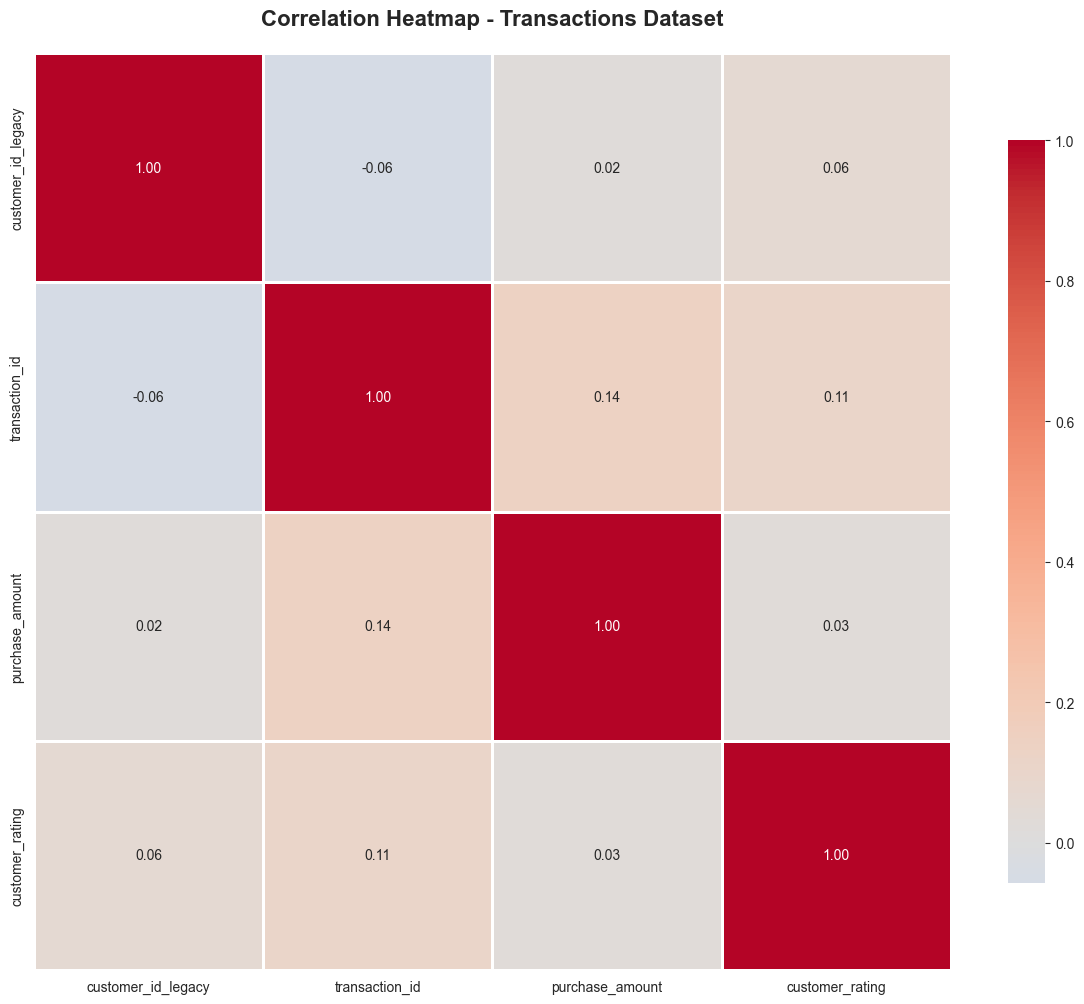

INTERPRETATION:
- Strong positive correlations (red) indicate variables that move together
- Strong negative correlations (blue) indicate inverse relationships
- Weak correlations (white) suggest independence between variables
- This helps identify redundant features and important relationships


In [8]:
# PLOT 3: CORRELATION HEATMAP
# Select numerical columns for correlation
correlation_data = transactions_df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_data, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap - Transactions Dataset', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('dataset/dataset_visualizations/plot3_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("INTERPRETATION:")
print("- Strong positive correlations (red) indicate variables that move together")
print("- Strong negative correlations (blue) indicate inverse relationships")
print("- Weak correlations (white) suggest independence between variables")
print("- This helps identify redundant features and important relationships")

4: EDA FOR SOCIAL PROFILES DATASET

EXPLORATORY DATA ANALYSIS - SOCIAL PROFILES DATASET
 Dataset Overview 
Shape: (155, 5)

Column Names and Types:
customer_id_new             object
social_media_platform       object
engagement_score             int64
purchase_interest_score    float64
review_sentiment            object
dtype: object
 Summary Statistics 
       engagement_score  purchase_interest_score
count        155.000000               155.000000
mean          75.606452                 3.152903
std           14.568021                 1.142867
min           50.000000                 1.000000
25%           63.500000                 2.350000
50%           77.000000                 3.200000
75%           87.500000                 4.100000
max           99.000000                 5.000000


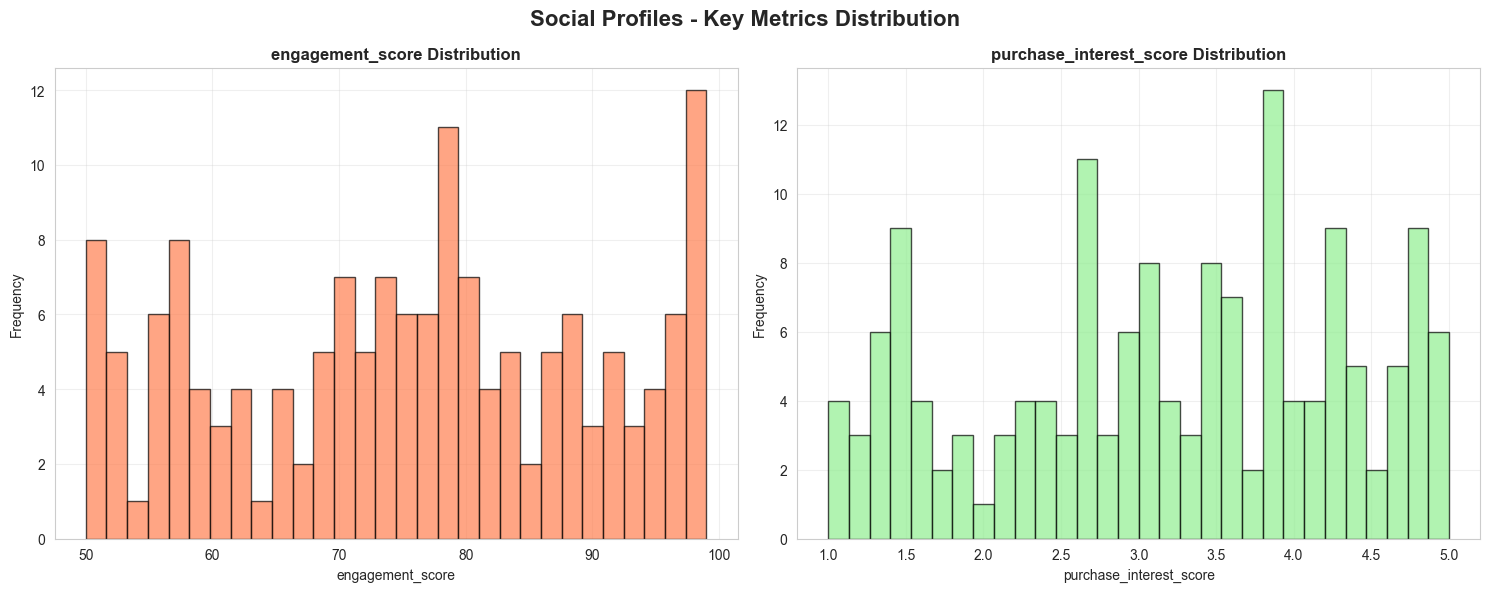

In [9]:
print("EXPLORATORY DATA ANALYSIS - SOCIAL PROFILES DATASET")
print(" Dataset Overview ")
print(f"Shape: {social_profiles_df.shape}")
print(f"\nColumn Names and Types:")
print(social_profiles_df.dtypes)

print(" Summary Statistics ")
print(social_profiles_df.describe())

# Additional visualization for social profiles
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Social Profiles - Key Metrics Distribution', fontsize=16, fontweight='bold')

# Plot engagement score if available
social_num_cols = social_profiles_df.select_dtypes(include=[np.number]).columns.tolist()
if len(social_num_cols) >= 2:
    axes[0].hist(social_profiles_df[social_num_cols[0]], bins=30, 
                 color='coral', alpha=0.7, edgecolor='black')
    axes[0].set_title(f'{social_num_cols[0]} Distribution', fontweight='bold')
    axes[0].set_xlabel(social_num_cols[0])
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(social_profiles_df[social_num_cols[1]], bins=30, 
                 color='lightgreen', alpha=0.7, edgecolor='black')
    axes[1].set_title(f'{social_num_cols[1]} Distribution', fontweight='bold')
    axes[1].set_xlabel(social_num_cols[1])
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dataset/dataset_visualizations/plot4_social_profiles.png', dpi=300, bbox_inches='tight')
plt.show()


5: DATA CLEANING

In [10]:
print("DATA CLEANING & PREPROCESSING")
def handle_nulls_and_duplicates(df, df_name):
    """Handle null values and duplicates in dataframe"""
    print(f"Handling Nulls and Duplicates for {df_name}")
    
    # Check for null values
    print("Null values before handling:")
    print(df.isnull().sum())
    
    # Handle null values based on column type
    for column in df.columns:
        if df[column].isnull().any():
            null_count = df[column].isnull().sum()
            if df[column].dtype in ['float64', 'int64']:
                # For numerical columns, fill with median
                median_val = df[column].median()
                df[column] = df[column].fillna(median_val)
                print(f"Filled {null_count} nulls in {column} with median: {median_val}")
            elif df[column].dtype == 'object':
                # For categorical columns, fill with mode
                mode_val = df[column].mode()[0] if not df[column].mode().empty else 'Unknown'
                df[column].fillna(mode_val, inplace=True)
                print(f"Filled {null_count} nulls in {column} with mode: {mode_val}")
    
    # Check for duplicates
    initial_rows = len(df)
    duplicates = df.duplicated().sum()
    print(f"Duplicate rows found: {duplicates}")
    
    if duplicates > 0:
        df.drop_duplicates(inplace=True)
        print(f"Removed {duplicates} duplicate rows")
    
    print(f"Rows after cleaning: {len(df)} (removed {initial_rows - len(df)})")
    return df

def fix_data_types(df, df_name):
    """Fix data types for optimal processing"""
    print(f"Fixing Data Types for {df_name}")
    
    print("Data types before fixing:")
    print(df.dtypes)
    
    # Convert date columns
    date_columns = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], format='mixed', errors='coerce')
            print(f"Converted {col} to datetime")
    
    # Convert ID columns to appropriate types
    id_columns = [col for col in df.columns if 'id' in col.lower()]
    for col in id_columns:
        if col in df.columns and df[col].dtype in ['float64', 'object']:
            try:
                df[col] = df[col].astype('Int64')
                print(f"Converted {col} to integer")
            except (ValueError, TypeError):
                df[col] = df[col].astype(str)
                print(f"Converted {col} to string")
    
    # Convert categorical columns
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() < 50]
    for col in categorical_columns:
        df[col] = df[col].astype('category')
        print(f"Converted {col} to category ({df[col].nunique()} unique values)")
    
    print("Data types after fixing:")
    print(df.dtypes)
    
    return df

# Apply cleaning
transactions_clean = handle_nulls_and_duplicates(transactions_df.copy(), "Transactions")
social_clean = handle_nulls_and_duplicates(social_profiles_df.copy(), "Social Profiles")

# Fix data types
transactions_clean = fix_data_types(transactions_clean, "Transactions")
social_clean = fix_data_types(social_clean, "Social Profiles")

DATA CLEANING & PREPROCESSING
Handling Nulls and Duplicates for Transactions
Null values before handling:
customer_id_legacy     0
transaction_id         0
purchase_amount        0
purchase_date          0
product_category       0
customer_rating       10
dtype: int64
Filled 10 nulls in customer_rating with median: 3.0
Duplicate rows found: 0
Rows after cleaning: 150 (removed 0)
Handling Nulls and Duplicates for Social Profiles
Null values before handling:
customer_id_new            0
social_media_platform      0
engagement_score           0
purchase_interest_score    0
review_sentiment           0
dtype: int64
Duplicate rows found: 5
Removed 5 duplicate rows
Rows after cleaning: 150 (removed 5)
Fixing Data Types for Transactions
Data types before fixing:
customer_id_legacy             int64
transaction_id                 int64
purchase_amount                int64
purchase_date         datetime64[ns]
product_category              object
customer_rating              float64
dtype: objec

6: MERGE LOGIC JUSTIFICATION

In [11]:
print("MERGE LOGIC & JUSTIFICATION")
def justify_join_logic(transactions_df, social_profiles_df):
    """Analyze and justify the join logic"""
    print(" Join Logic Justification")
    
    # Analyze customer ID mapping
    transactions_customers = set(transactions_df['customer_id_legacy'].astype(int).astype(str))
    social_customers = set(social_profiles_df['customer_id_new'].str.replace('A', '').astype(int).astype(str))
    
    common_customers = transactions_customers.intersection(social_customers)
    only_transactions = transactions_customers - social_customers
    only_social = social_customers - transactions_customers
    
    print(f"Total unique customers in transactions: {len(transactions_customers)}")
    print(f"Total unique customers in social profiles: {len(social_customers)}")
    print(f"Common customers (can be merged): {len(common_customers)}")
    print(f"Customers only in transactions: {len(only_transactions)}")
    print(f"Customers only in social profiles: {len(only_social)}")
    
    # Calculate overlap percentages
    trans_overlap = len(common_customers) / len(transactions_customers) * 100
    social_overlap = len(common_customers) / len(social_customers) * 100
    
    print(f"Overlap analysis:")
    print(f"{trans_overlap:.1f}% of transaction customers have social profiles")
    print(f"{social_overlap:.1f}% of social profile customers have transactions")
    
    # Justify inner join choice
    print(f"JOIN TYPE SELECTED: INNER JOIN")
    print("Justification:")
    print("  1. We want only customers who exist in BOTH datasets")
    print("  2. This ensures complete customer profiles (both transaction and social data)")
    print("  3. Avoids null values for key customer attributes")
    print("  4. Maintains data integrity for predictive modeling")
    print("  5. Ensures all features are available for each customer")
    
    return len(common_customers) > 0

# Justify merge
if not justify_join_logic(transactions_clean, social_clean):
    print("WARNING: No common customers found! Check ID mapping.")

# Prepare for merge
transactions_clean['customer_id_common'] = transactions_clean['customer_id_legacy'].astype(int).astype(str)
social_clean['customer_id_common'] = social_clean['customer_id_new'].str.replace('A', '').astype(int).astype(str)

MERGE LOGIC & JUSTIFICATION
 Join Logic Justification
Total unique customers in transactions: 75
Total unique customers in social profiles: 84
Common customers (can be merged): 61
Customers only in transactions: 14
Customers only in social profiles: 23
Overlap analysis:
81.3% of transaction customers have social profiles
72.6% of social profile customers have transactions
JOIN TYPE SELECTED: INNER JOIN
Justification:
  1. We want only customers who exist in BOTH datasets
  2. This ensures complete customer profiles (both transaction and social data)
  3. Avoids null values for key customer attributes
  4. Maintains data integrity for predictive modeling
  5. Ensures all features are available for each customer


7: PERFORM MERGE

In [12]:
print("PERFORMING DATA MERGE")
# Perform inner join
merged_df = pd.merge(
    transactions_clean,
    social_clean,
    on='customer_id_common',
    how='inner',
    validate='many_to_many'
)
print(f"Merged dataset shape: {merged_df.shape}")

PERFORMING DATA MERGE
Merged dataset shape: (213, 12)


8: POST-MERGE VALIDATION

In [13]:
print("POST-MERGE QUALITY CHECKS")
def perform_post_merge_checks(merged_df, original_transactions, original_social):
    """Perform comprehensive checks after merge"""
    
    # Basic shape and size checks
    print(f" Shape Validation")
    print(f"Merged dataset shape: {merged_df.shape}")
    print(f"Expected columns: {len(original_transactions.columns) + len(original_social.columns) - 1}")
    
    # Check for null values in merged data
    print(" Null Value Check")
    null_summary = merged_df.isnull().sum()
    total_nulls = null_summary.sum()
    if total_nulls == 0:
        print("No null values in merged dataset")
    else:
        print(f"Null values found in {(null_summary > 0).sum()} columns:")
        for col, null_count in null_summary.items():
            if null_count > 0:
                print(f"  {col}: {null_count} nulls ({null_count/len(merged_df)*100:.1f}%)")
    
    # Check for duplicates
    print(" Duplicate Check ")
    merged_duplicates = merged_df.duplicated().sum()
    if merged_duplicates == 0:
        print(" No duplicate rows in merged dataset")
    else:
        print(f" Found {merged_duplicates} duplicate rows")
    
    # Verify customer count
    print(" Customer Count Validation")
    unique_customers = merged_df['customer_id_common'].nunique()
    print(f"Unique customers in merged data: {unique_customers}")
    
    # Data integrity checks
    print(" Data Integrity Checks")
    checks_passed = 0
    total_checks = 0
    
    # Check 1: Customer IDs are strings
    total_checks += 1
    if merged_df['customer_id_common'].dtype == 'object':
        print(" Customer IDs are properly formatted as strings")
        checks_passed += 1
    else:
        print(" Customer IDs are not strings")
    
    # Check 2: No negative values in amount columns
    amount_cols = [col for col in merged_df.columns if 'amount' in col.lower() or 'price' in col.lower()]
    for col in amount_cols:
        if col in merged_df.columns:
            total_checks += 1
            if (merged_df[col] >= 0).all():
                print(f"No negative values in {col}")
                checks_passed += 1
            else:
                print(f"Found negative values in {col}")
    
    print(f"Integrity Score: {checks_passed}/{total_checks} checks passed")

perform_post_merge_checks(merged_df, transactions_clean, social_clean)

POST-MERGE QUALITY CHECKS
 Shape Validation
Merged dataset shape: (213, 12)
Expected columns: 12
 Null Value Check
Null values found in 1 columns:
  review_sentiment: 213 nulls (100.0%)
 Duplicate Check 
 No duplicate rows in merged dataset
 Customer Count Validation
Unique customers in merged data: 61
 Data Integrity Checks
 Customer IDs are properly formatted as strings
No negative values in purchase_amount
Integrity Score: 2/2 checks passed


9: SAVE MERGED DATASET

In [14]:
print("SAVING MERGED DATASET")
merged_file_path = 'dataset/merged_customer_data.xlsx'
merged_df.to_excel(merged_file_path, index=False)

print(f" Merged dataset saved to: {merged_file_path}")

# Final summary
print(f"FINAL SUMMARY")
print(f"Original transactions: {len(transactions_df)} records")
print(f"After cleaning: {len(transactions_clean)} records")
print(f"Original social profiles: {len(social_profiles_df)} records")
print(f"After cleaning: {len(social_clean)} records")
print(f"Final merged dataset: {len(merged_df)} records")
print(f"Merge efficiency: {len(merged_df)/len(transactions_clean)*100:.1f}% of cleaned transactions matched")

print("Sample of Merged Data (First 5 Rows)")
print(merged_df.head())


SAVING MERGED DATASET
 Merged dataset saved to: dataset/merged_customer_data.xlsx
FINAL SUMMARY
Original transactions: 150 records
After cleaning: 150 records
Original social profiles: 155 records
After cleaning: 150 records
Final merged dataset: 213 records
Merge efficiency: 142.0% of cleaned transactions matched
Sample of Merged Data (First 5 Rows)
   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 151            1001              408    2024-01-01   
1                 151            1001              408    2024-01-01   
2                 151            1001              408    2024-01-01   
3                 192            1002              332    2024-01-02   
4                 114            1003              442    2024-01-03   

  product_category  customer_rating customer_id_common customer_id_new  \
0           Sports              2.3                151            A151   
1           Sports              2.3                151            

## 1.1. Product Recommendation Model
This section builds a Product Recommendation Model using XGBoost to predict which product a customer is likely to purchase based on their profile.

**This part will cover:**

1. Loading the merged customer dataset
2. Feature engineering and selection
3. Building a Product Recommendation Model
4. Model evaluation with Accuracy, F1-Score, and Loss

In [15]:
# Necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, log_loss
import joblib
import os
from xgboost import XGBClassifier

In [16]:
# Load merged dataset
merged_df = pd.read_excel('dataset/merged_customer_data.xlsx')
print(f"Columns: {list(merged_df.columns)}")

Columns: ['customer_id_legacy', 'transaction_id', 'purchase_amount', 'purchase_date', 'product_category', 'customer_rating', 'customer_id_common', 'customer_id_new', 'social_media_platform', 'engagement_score', 'purchase_interest_score', 'review_sentiment']


**IDENTIFY TARGET VARIABLE**

In [17]:
possible_targets = ['product', 'product_category', 'product_type', 
                   'purchase_category', 'item_category', 'category']

target_column = None
for col in possible_targets:
    if col in merged_df.columns:
        target_column = col
        break
if target_column is None:
    print("Available columns:", list(merged_df.columns))
else:
    print(f"Target variable: '{target_column}'")
    print(merged_df[target_column].value_counts())
    print(f"Total categories: {merged_df[target_column].nunique()}")


Target variable: 'product_category'
product_category
Sports         59
Electronics    45
Groceries      38
Books          38
Clothing       33
Name: count, dtype: int64
Total categories: 5


In [18]:
# PREPARE FEATURES AND TARGET
df_model = merged_df.copy()
# Columns to exclude from features
exclude_cols = ['customer_id_common', 'customer_id_legacy', 'customer_id_new']
# Add date columns to exclude
date_cols = df_model.select_dtypes(include=['datetime64']).columns.tolist()
exclude_cols.extend(date_cols)
# Add target column to exclude
if target_column:
    exclude_cols.append(target_column)
# Remove columns that exist
exclude_cols = [col for col in exclude_cols if col in df_model.columns]
print(f"Excluding: {exclude_cols}")

# Create feature matrix (X) and target (y)
X = df_model.drop(columns=exclude_cols, errors='ignore')
y = df_model[target_column]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {list(X.columns)}")

Excluding: ['customer_id_common', 'customer_id_legacy', 'customer_id_new', 'purchase_date', 'product_category']
Features shape: (213, 7)
Target shape: (213,)
Feature columns: ['transaction_id', 'purchase_amount', 'customer_rating', 'social_media_platform', 'engagement_score', 'purchase_interest_score', 'review_sentiment']


**ENCODE CATEGORICAL VARIABLES**

In [19]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist() # identification of categorical variables

print(f"Numerical: {numerical_cols}")
# Encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}")

# Encode target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print(f"Target encoded into {len(le_target.classes_)} classes")
print(f"Classes: {le_target.classes_}")


Numerical: ['transaction_id', 'purchase_amount', 'customer_rating', 'engagement_score', 'purchase_interest_score', 'review_sentiment']
Encoded social_media_platform
Target encoded into 5 classes
Classes: ['Books' 'Clothing' 'Electronics' 'Groceries' 'Sports']


**Split data into train and test sets**

In [20]:
# SPLITTING DATA (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)
X_train_final = X_train
X_test_final = X_test

**Train XGBoost model**

The XGBoost model was ideal for this project due to its efficient algorithm for product recommendation, which effectively handles complex customer patterns. XGBoost excels at predicting product categories based on multiple customer attributes, including:
1. Customer ratings and engagement scores from social media
1. Purchase history and transaction patterns

The XGBoost is also capable of  handling diverse feature types gracefully:
1. Numerical features (purchase amounts, ratings, engagement metrics)
2. Categorical features (customer segments, product types, demographics)

In [21]:
# Create and train XGBoost model
model = XGBClassifier(
    n_estimators=200,           # Number of boosting rounds
    max_depth=6,                # Maximum tree depth
    learning_rate=0.1,          # Step size shrinkage
    subsample=0.8,              # Fraction of samples for each tree
    colsample_bytree=0.8,       # Fraction of features for each tree
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss',     # Evaluation metric     # Avoid warning
)

model.fit(X_train_final, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

**Make predictions and Evaluate model performance using F1 Score, Loss & Accuracy**

In [22]:
y_pred = model.predict(X_test_final)
y_pred_proba = model.predict_proba(X_test_final)
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
loss = log_loss(y_test, y_pred_proba)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score:  {f1:.4f}")
print(f"Log Loss:  {loss:.4f}")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))

Accuracy:  0.5581 (55.81%)
F1-Score:  0.5504
Log Loss:  1.3800
              precision    recall  f1-score   support

       Books       0.60      0.38      0.46         8
    Clothing       0.71      0.83      0.77         6
 Electronics       0.27      0.33      0.30         9
   Groceries       0.50      0.38      0.43         8
      Sports       0.71      0.83      0.77        12

    accuracy                           0.56        43
   macro avg       0.56      0.55      0.55        43
weighted avg       0.56      0.56      0.55        43



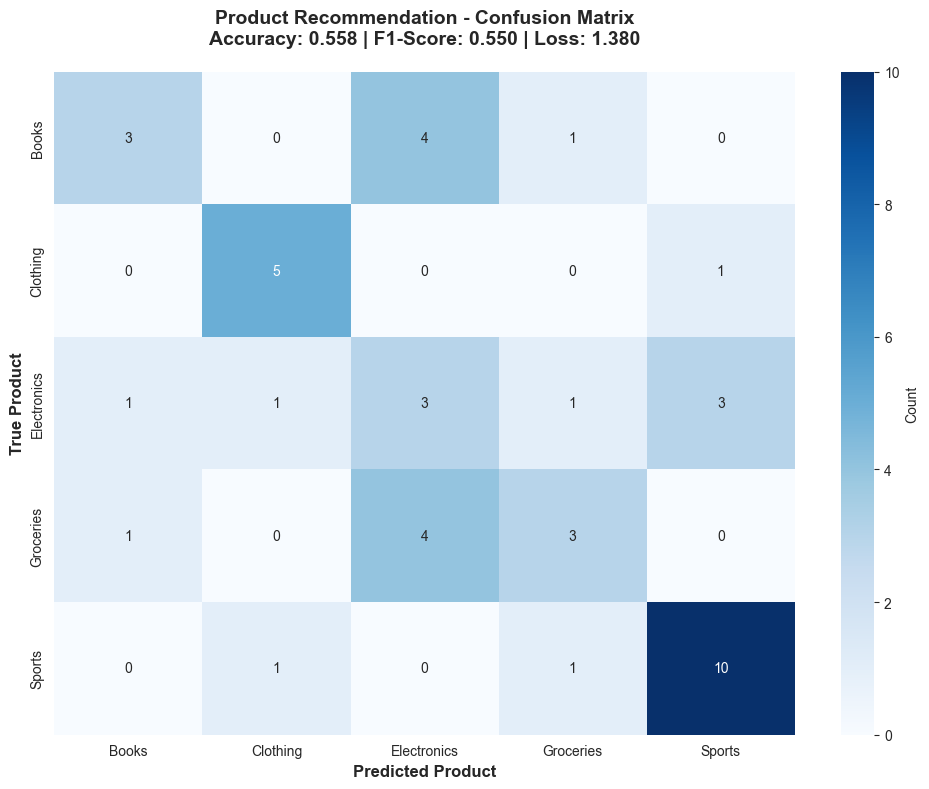

Confusion matrix saved: product_model_confusion_matrix.png


In [24]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_, 
            yticklabels=le_target.classes_,
            cbar_kws={'label': 'Count'})

plt.title(f'Product Recommendation - Confusion Matrix\nAccuracy: {accuracy:.3f} | F1-Score: {f1:.3f} | Loss: {loss:.3f}', 
         fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Product', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Product', fontsize=12, fontweight='bold')
plt.tight_layout()

# 🔧 FIX: Make sure the folder exists
os.makedirs("product_recommendation_model", exist_ok=True)

plt.savefig('product_recommendation_model/product_model_confusion_matrix.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved: product_model_confusion_matrix.png")


**Feature Importance**

Top 10 Most Important Features:
                Feature  Importance
         transaction_id    0.221353
        customer_rating    0.174783
        purchase_amount    0.166978
       engagement_score    0.148426
purchase_interest_score    0.146033
  social_media_platform    0.142427
       review_sentiment    0.000000


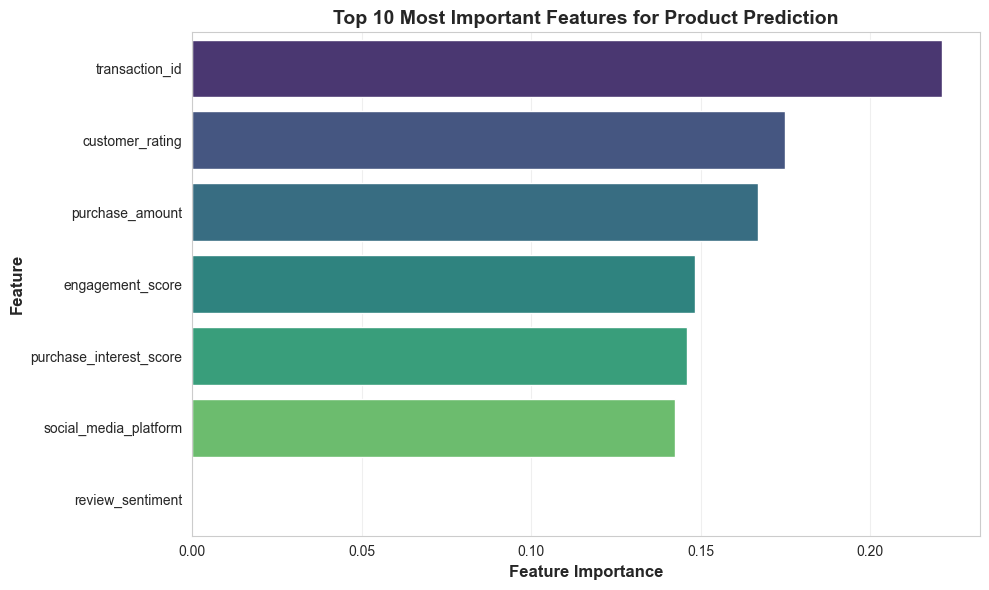

In [25]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

print("Top 10 Most Important Features:")
print(feature_importance.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title('Top 10 Most Important Features for Product Prediction', 
         fontsize=14, fontweight='bold')
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('product_recommendation_model/product_model_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

**Save Model**

In [26]:
# Create models directory
os.makedirs('product_recommendation_model', exist_ok=True)
# Save model and encoders
joblib.dump(model, 'product_recommendation_model/product_recommendation_model.pkl')
joblib.dump(le_target, 'product_recommendation_model/product_label_encoder.pkl')
joblib.dump(label_encoders, 'product_recommendation_model/product_feature_encoders.pkl')

['product_recommendation_model/product_feature_encoders.pkl']

**Test Sample Prediction**

In [27]:
sample_idx = 0
sample_features = X_test_final.iloc[sample_idx:sample_idx+1]
sample_prediction = model.predict(sample_features)[0]
sample_proba = model.predict_proba(sample_features)[0]
predicted_product = le_target.inverse_transform([sample_prediction])[0]

print("Sample customer features:")
for col, val in sample_features.iloc[0].items():
    print(f"  {col}: {val}")

print(f"PREDICTED PRODUCT: {predicted_product}")
print(f"Confidence: {sample_proba.max():.2%}")

print("Prediction probabilities:")
for i, prob in enumerate(sample_proba):
    print(f"  {le_target.classes_[i]}: {prob:.2%}")

Sample customer features:
  transaction_id: 1119.0
  purchase_amount: 421.0
  customer_rating: 3.2
  social_media_platform: 4.0
  engagement_score: 96.0
  purchase_interest_score: 1.9
  review_sentiment: nan
PREDICTED PRODUCT: Sports
Confidence: 64.49%
Prediction probabilities:
  Books: 8.79%
  Clothing: 20.84%
  Electronics: 3.87%
  Groceries: 2.01%
  Sports: 64.49%


# Part 2: Image Data Loading and Preview


In this section, we are working with our facial images that have the three expressions: **neutral**, **smile**, and **surprised**. we  will load them, organize them properly, and display a few samples to confirm everything is in the right place.

### Goal

Load the images and label them by member + expression
Preview the pictures before moving to augmentation and feature extraction


In [28]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import cv2

IMG_DIR = Path("Face_Recognition/images")

rows = []
for p in IMG_DIR.glob("*.jpg"):
    name = p.stem                  # e.g. tracy_neutral
    person, expr = name.split("_") # tracy, neutral
    if expr == "suprised":
        expr = "surprised"
    rows.append({
        "member": person,
        "expression": expr,
        "filename": str(p)
    })

img_df = pd.DataFrame(rows)
img_df


member expression                                     filename
0   carine    neutral   Face_Recognition\images\carine_neutral.jpg
1   carine      smile     Face_Recognition\images\carine_smile.jpg
2   carine  surprised  Face_Recognition\images\carine_suprised.jpg
3     emmy    neutral     Face_Recognition\images\emmy_neutral.jpg
4     emmy      smile       Face_Recognition\images\emmy_smile.jpg
5     emmy  surprised    Face_Recognition\images\emmy_suprised.jpg
6      eva    neutral      Face_Recognition\images\eva_neutral.jpg
7      eva      smile        Face_Recognition\images\eva_smile.jpg
8      eva  surprised     Face_Recognition\images\eva_suprised.jpg
9    tracy    neutral    Face_Recognition\images\tracy_neutral.jpg
10   tracy      smile      Face_Recognition\images\tracy_smile.jpg
11   tracy  surprised   Face_Recognition\images\tracy_suprised.jpg

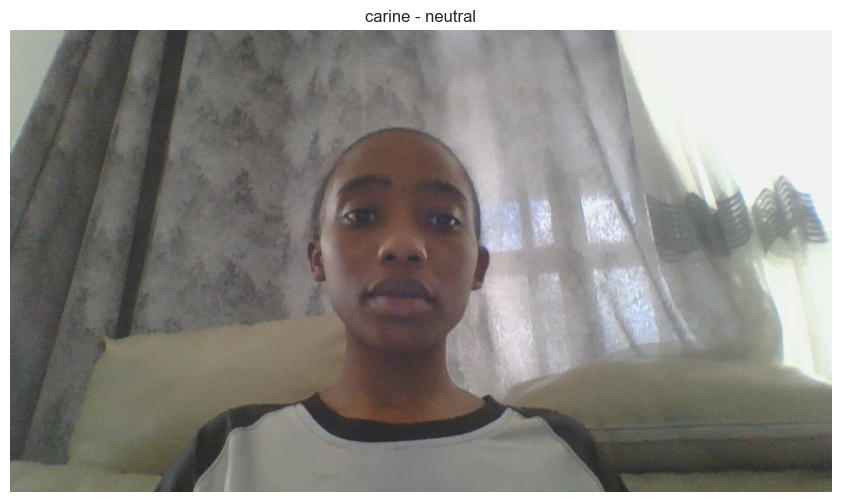

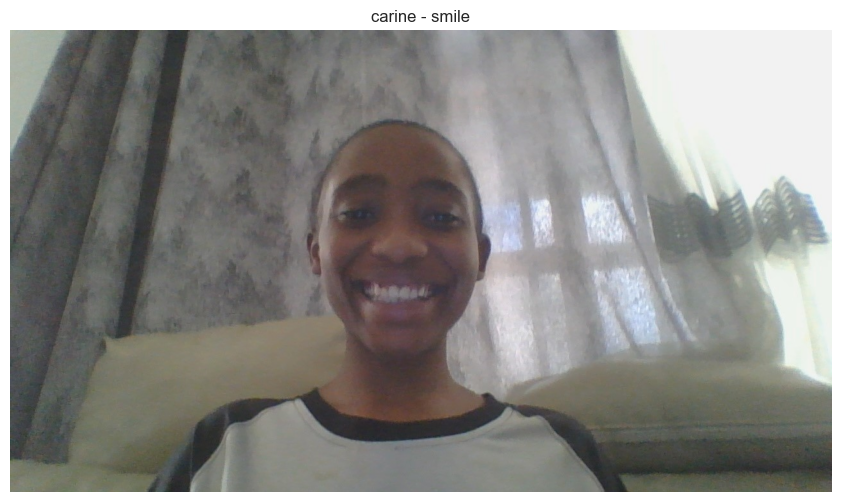

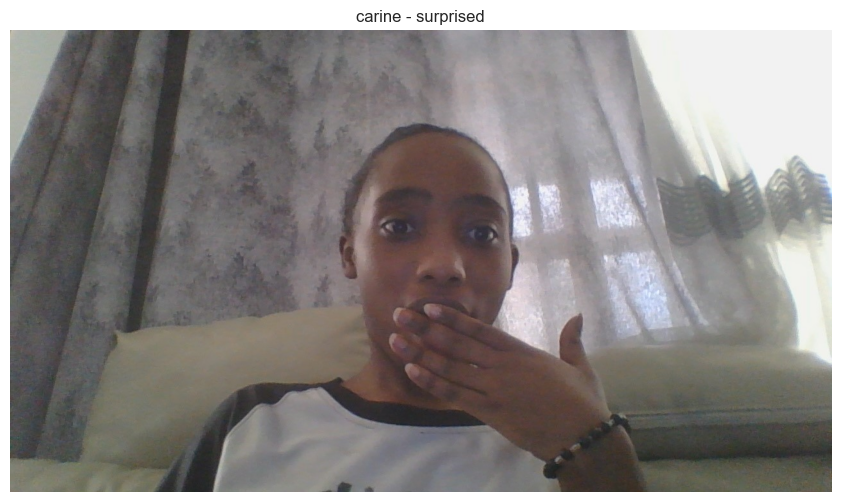

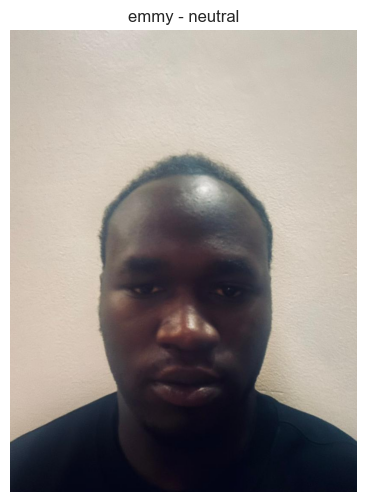

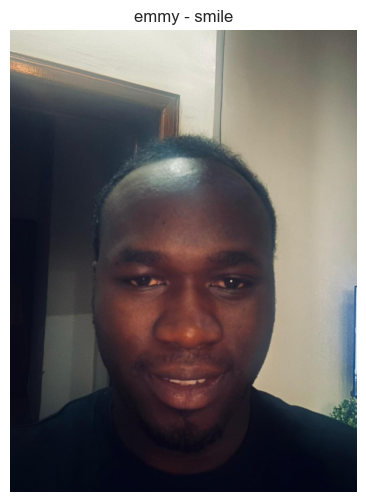

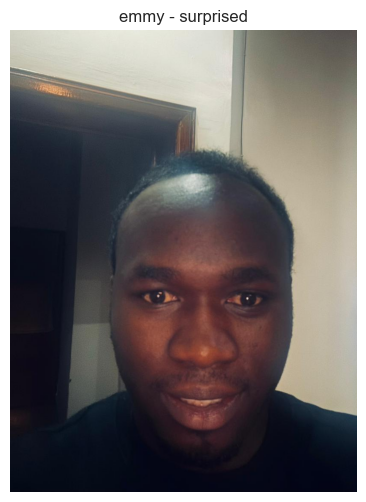

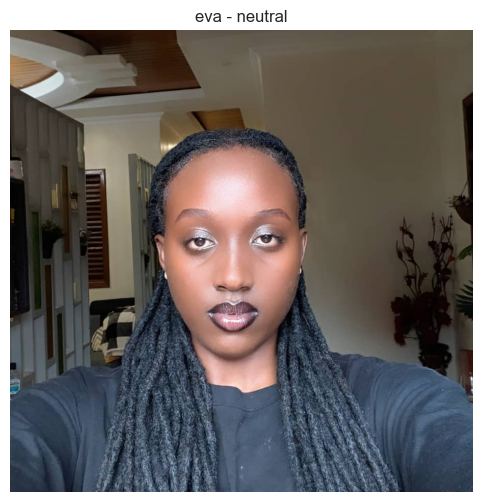

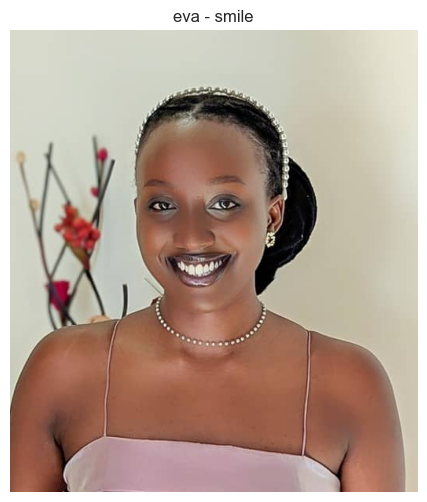

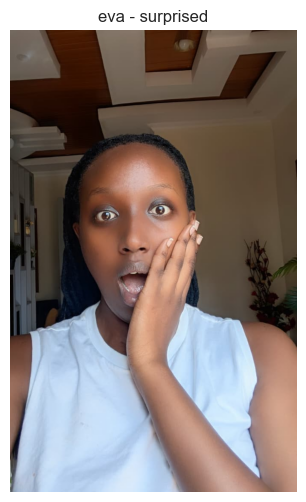

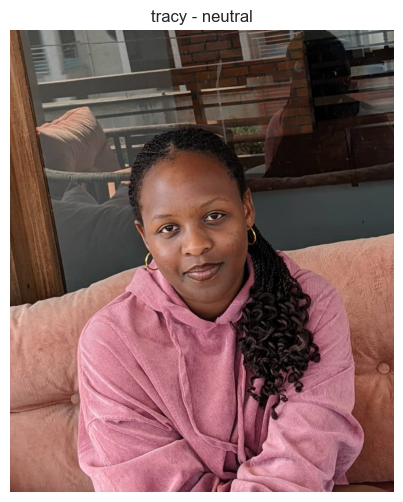

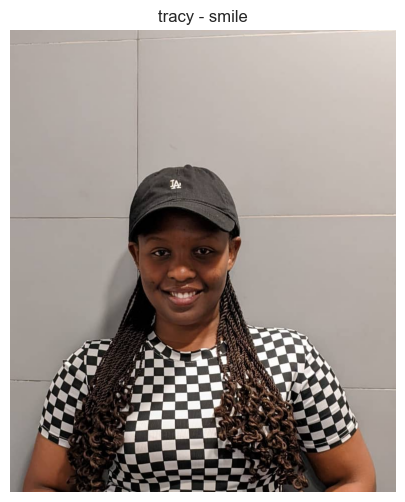

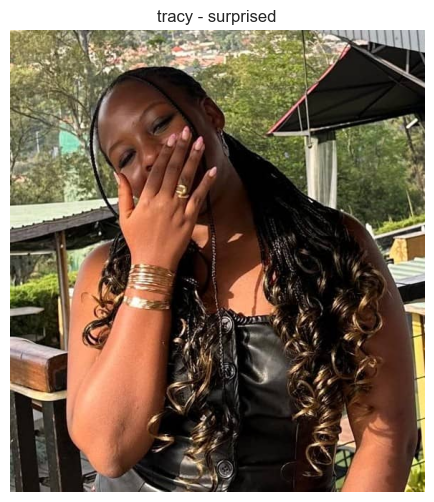

In [29]:
for _, row in img_df.iterrows():
    img = cv2.imread(row["filename"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{row['member']} - {row['expression']}")
    plt.show()


## Image Augmentation

In this part we created new versions of each face image.
For every original picture (neutral, smile, surprised), we made few changed copies (rotated, flipped, grayscale, brighter).

This helps the model see more variety and makes the face recognition more robust.

In [30]:
from pathlib import Path
import cv2
import numpy as np

IMG_DIR = Path("Face_Recognition/images")
AUG_DIR = Path("Face_Recognition/images_aug")
AUG_DIR.mkdir(exist_ok=True)

def rotate(img, deg=10):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), deg, 1.0)
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)

def hflip(img):
    return cv2.flip(img, 1)

def to_gray3(img):
    """grayscale but keep 3 channels for later models"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

def adjust_brightness(img, factor=1.15):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[..., 2] = np.clip(hsv[..., 2] * factor, 0, 255)
    hsv = hsv.astype(np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)


In [31]:
aug_count = 0

for _, row in img_df.iterrows():
    img_path = Path(row["filename"])
    img = cv2.imread(str(img_path))

    stem = img_path.stem  # e.g. tracy_neutral

    # 1) rotated +10 degrees
    cv2.imwrite(str(AUG_DIR / f"{stem}_rot.jpg"), rotate(img, 10))

    # 2) horizontally flipped
    cv2.imwrite(str(AUG_DIR / f"{stem}_flip.jpg"), hflip(img))

    # 3) grayscale (3-channel)
    cv2.imwrite(str(AUG_DIR / f"{stem}_gray.jpg"), to_gray3(img))

    # 4) brighter
    cv2.imwrite(str(AUG_DIR / f"{stem}_bright.jpg"), adjust_brightness(img, 1.15))

    aug_count += 4

print(f"Created {aug_count} augmented images in {AUG_DIR}")


Created 48 augmented images in Face_Recognition\images_aug


Cell below is a quick check that displays one random augmented image to confirm that all generated images were created and loaded correctly.


48 augmented images found


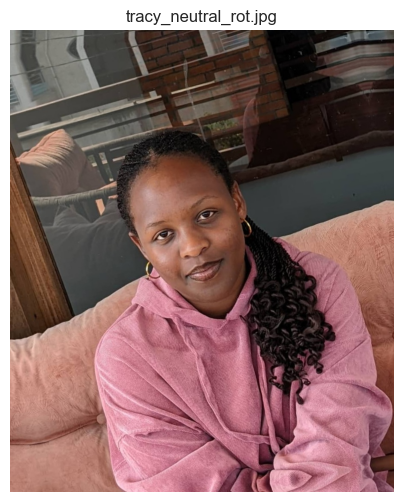

In [33]:
from random import choice

aug_files = list(AUG_DIR.glob("*.jpg"))
print(len(aug_files), "augmented images found")

sample = choice(aug_files)
img = cv2.imread(str(sample))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.title(sample.name)
plt.show()


 # 2.1. Face Recognition Model (SVM)

 This section builds a Face Recognition Model using Support Vector Machine (SVM)
to identify team members from their facial features.

In [34]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, log_loss
import joblib
import os

 **LOAD IMAGE FEATURES**

In [35]:
# Load image features
image_features_df = pd.read_csv('Face_Recognition/image_features.csv')
print(f"Image features loaded: {image_features_df.shape}")
print(image_features_df.head())

Image features loaded: (60, 1030)
              filename  folder  member expression  width  height     emb_0  \
0   carine_neutral.jpg  images  carine    neutral   1280     720  1.340442   
1     carine_smile.jpg  images  carine      smile   1280     720  0.543590   
2  carine_suprised.jpg  images  carine  surprised   1280     720  1.517195   
3     emmy_neutral.jpg  images    emmy    neutral    810    1080  1.775303   
4       emmy_smile.jpg  images    emmy      smile    810    1080  1.088357   

      emb_1     emb_2     emb_3  ...  hist_502  hist_503  hist_504  hist_505  \
0  0.237362  0.236695  1.158674  ...       0.0       0.0       0.0       0.0   
1  0.259642  0.183224  1.319227  ...       0.0       0.0       0.0       0.0   
2  0.322522  0.551286  1.332942  ...       0.0       0.0       0.0       0.0   
3  0.501361  0.168460  1.195993  ...       0.0       0.0       0.0       0.0   
4  1.052977  0.974002  1.363536  ...       0.0       0.0       0.0       0.0   

   hist_506  his

In [36]:
def extract_person_name(filename):
    # Remove file extension (.jpg, .png, etc.)
    name_without_ext = filename.rsplit('.', 1)[0]
    
    # Split by underscore
    parts = name_without_ext.split('_')
    
    # Take first part (person's name)
    person_name = parts[0]
    
    # Capitalize properly
    person_name = person_name.capitalize()
    
    return person_name

# Show sample filenames before extraction
print("Sample filenames:")
sample_filenames = image_features_df['filename'].head(10).tolist()
for fname in sample_filenames:
    print(f"  {fname} → {extract_person_name(fname)}")

# Create member_name column
image_features_df['member_name'] = image_features_df['filename'].apply(extract_person_name)

print("Successfully extracted person names")

# Set target column
target_col = 'member_name'

print(f"Team Members Identified")
print(f"Unique members: {image_features_df[target_col].nunique()}")
print(f"Team members: {sorted(image_features_df[target_col].unique())}")

print(f"Images per Member")
print(image_features_df[target_col].value_counts().sort_index())

total_images = len(image_features_df)
print(f"Total images: {total_images}")

Sample filenames:
  carine_neutral.jpg → Carine
  carine_smile.jpg → Carine
  carine_suprised.jpg → Carine
  emmy_neutral.jpg → Emmy
  emmy_smile.jpg → Emmy
  emmy_suprised.jpg → Emmy
  eva_neutral.jpg → Eva
  eva_smile.jpg → Eva
  eva_suprised.jpg → Eva
  tracy_neutral.jpg → Tracy
Successfully extracted person names
Team Members Identified
Unique members: 4
Team members: ['Carine', 'Emmy', 'Eva', 'Tracy']
Images per Member
member_name
Carine    15
Emmy      15
Eva       15
Tracy     15
Name: count, dtype: int64
Total images: 60


**PREPARE FEATURES AND TARGET**

In [37]:
# Columns to exclude (non-feature columns)
exclude_cols = [target_col, 'filename']
# Add any other metadata columns that might exist
other_metadata = ['expression', 'image_path', 'file_name', 'augmentation', 
                 'type', 'label', 'image_name']
for col in other_metadata:
    if col in image_features_df.columns and col not in exclude_cols:
        exclude_cols.append(col)
print(f"Excluding non-feature columns: {exclude_cols}")
# Get all non-numeric columns
non_numeric_cols = image_features_df.select_dtypes(include=['object']).columns.tolist()
print(f"Non-numeric columns found: {non_numeric_cols}")
# Add all non-numeric to exclusion list
for col in non_numeric_cols:
    if col not in exclude_cols:
        exclude_cols.append(col)
# Create feature matrix (X) - only numeric columns
X = image_features_df.drop(columns=exclude_cols, errors='ignore')
# Double-check: keep only numeric columns
X = X.select_dtypes(include=[np.number])
# Create target (y)
y = image_features_df[target_col]
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {X.shape[1]}")
# Check for missing values
missing_count = X.isnull().sum().sum()
if missing_count > 0:
    print(f"Found {missing_count} missing values - filling with 0")
    X = X.fillna(0)
else:
    print("No missing values")
# Check for infinite values
inf_count = np.isinf(X.values).sum()
if inf_count > 0:
    print(f"Found {inf_count} infinite values - replacing with 0")
    X = X.replace([np.inf, -np.inf], 0)
else:
    print("No infinite values")

Excluding non-feature columns: ['member_name', 'filename', 'expression']
Non-numeric columns found: ['filename', 'folder', 'member', 'expression', 'member_name']
Features shape: (60, 1026)
Target shape: (60,)
Number of features: 1026
No missing values
No infinite values


**Encode Target**

In [38]:
#Encode target
le_face = LabelEncoder()
y_encoded = le_face.fit_transform(y)

print(f"Team members encoded into {len(le_face.classes_)} classes:")
for i, name in enumerate(le_face.classes_):
    count = (y_encoded == i).sum()
    print(f"  {i}: {name} ({count} images)")

print(f"Total samples: {len(y_encoded)}")

Team members encoded into 4 classes:
  0: Carine (15 images)
  1: Emmy (15 images)
  2: Eva (15 images)
  3: Tracy (15 images)
Total samples: 60


**Split data into test and train sets**

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# Show distribution
print("Training set distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for idx, count in zip(unique, counts):
    print(f"  {le_face.classes_[idx]}: {count} images")

Training samples: 48
Test samples: 12
Training set distribution:
  Carine: 12 images
  Emmy: 12 images
  Eva: 12 images
  Tracy: 12 images


**Scale Features**

In [40]:
scaler_face = StandardScaler()
X_train_scaled = scaler_face.fit_transform(X_train)
X_test_scaled = scaler_face.transform(X_test)
print(f"Scaled training shape: {X_train_scaled.shape}")
print(f"Scaled test shape: {X_test_scaled.shape}")

Scaled training shape: (48, 1026)
Scaled test shape: (12, 1026)


**Train SVM model**

The Support Vector Machine (SVM) was ideal for this project due to its:
1. Excellence in high-dimensional data (image features/embeddings)
2. Works great with small datasets.
3. Fast training and prediction.
4. Industry standard for face recognition

In [41]:
# Create and train SVM
face_model = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    probability=True,
    random_state=42
)

face_model.fit(X_train_scaled, y_train)

SVC(C=10, probability=True, random_state=42)

**Make predictions and Evaluate model**

In [42]:
y_pred = face_model.predict(X_test_scaled)
y_pred_proba = face_model.predict_proba(X_test_scaled)
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
loss = log_loss(y_test, y_pred_proba)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score:  {f1:.4f}")
print(f"Log Loss:  {loss:.4f}")
print(classification_report(y_test, y_pred, target_names=le_face.classes_))

Accuracy:  0.8333 (83.33%)
F1-Score:  0.8375
Log Loss:  0.5120
              precision    recall  f1-score   support

      Carine       1.00      1.00      1.00         3
        Emmy       1.00      0.67      0.80         3
         Eva       1.00      0.67      0.80         3
       Tracy       0.60      1.00      0.75         3

    accuracy                           0.83        12
   macro avg       0.90      0.83      0.84        12
weighted avg       0.90      0.83      0.84        12



**Plot Confusion matrix**

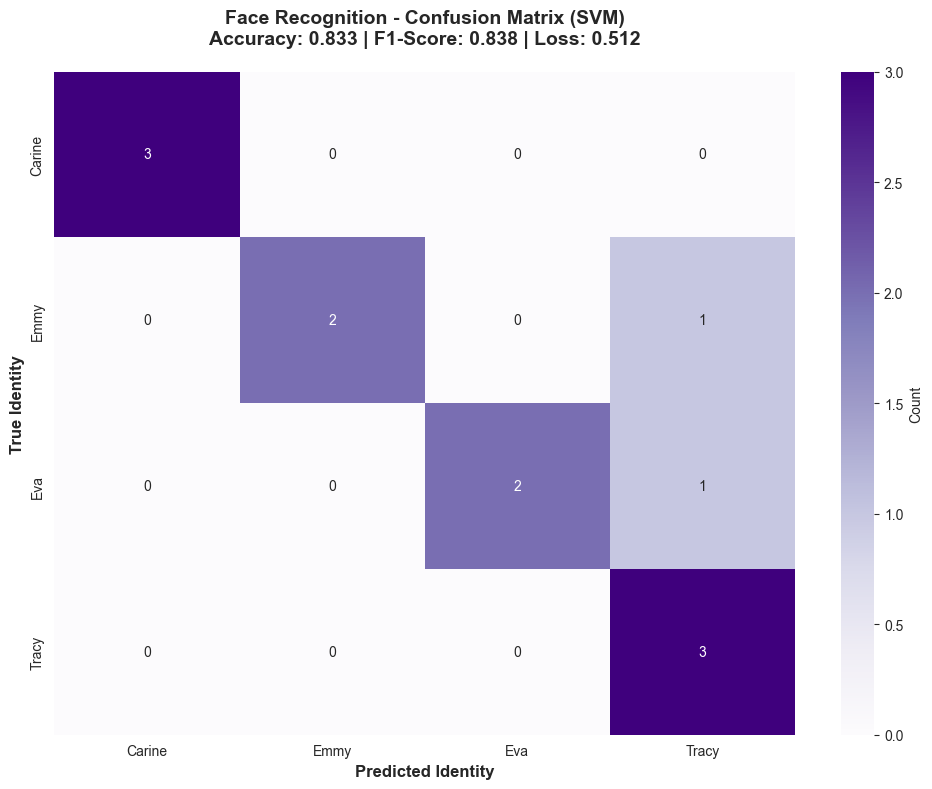

In [43]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=le_face.classes_,
            yticklabels=le_face.classes_,
            cbar_kws={'label': 'Count'})

plt.title(f'Face Recognition - Confusion Matrix (SVM)\nAccuracy: {accuracy:.3f} | F1-Score: {f1:.3f} | Loss: {loss:.3f}',
         fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Identity', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Identity', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('Face_Recognition/models/face_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

**Save Model**

In [44]:
# Create models directory
os.makedirs('Face_Recognition/models', exist_ok=True)

# Save model components
joblib.dump(face_model, 'Face_Recognition/models/face_recognition_model.pkl')
joblib.dump(scaler_face, 'Face_Recognition/models/face_scaler.pkl')
joblib.dump(le_face, 'Face_Recognition/models/face_label_encoder.pkl')

['Face_Recognition/models/face_label_encoder.pkl']

**Test Sample Prediction**

In [45]:
def test_face_from_file(image_filename):
    print(f"FACE AUTHENTICATION TEST")
    # Find the image in the dataset
    row = image_features_df[image_features_df['filename'].str.contains(image_filename, na=False)]
    
    if row.empty:
        print(f"ERROR: Not found!")
        print(f"ACCESS DENIED! - Unauthorised Person")
        return None, 0
    
    # Use the first match
    row = row.iloc[0]
    
    # Extract features (all columns except metadata)
    feature_vector = row.drop(labels=exclude_cols, errors='ignore').values
    actual_name = row[target_col]
    
    print(f"Testing image: {row['filename']}")
    print(f"Actual person: {actual_name}")

    emb_cols = [col for col in image_features_df.columns if 'emb_' in col]
    if emb_cols:
        print(f"Number of embeddings: {len(emb_cols)}")
        print(f"Sample embeddings: emb_0={row['emb_0']:.4f}, emb_1={row['emb_1']:.4f}")
    
    
    # Scale features
    features_scaled = scaler_face.transform(feature_vector.reshape(1, -1))
    
    # Predict
    prediction = face_model.predict(features_scaled)[0]
    probabilities = face_model.predict_proba(features_scaled)[0]
    predicted_name = le_face.inverse_transform([prediction])[0]
    confidence = probabilities.max()
    
    print(f"Predicted match: {predicted_name}")
    print(f"Confidence: {confidence:.2%}")
    
    # Decision
    if confidence >= 0.70:
        print(f"ACCESS GRANTED - Welcome, {predicted_name}!")
        if predicted_name == actual_name:
            print(f"CORRECT PREDICTION")
        else:
            print(f"WRONG (should be {actual_name})")
    else:
        print(f"ACCESS DENIED - Unauthorized person")
    
    return predicted_name, confidence

In [46]:
# Test with Random images
test_face_from_file("jeje_neutral_bright.jpg")

FACE AUTHENTICATION TEST
ERROR: Not found!
ACCESS DENIED! - Unauthorised Person


(None, 0)

In [47]:
# Test with images from dataset
test_face_from_file("eva_neutral_bright.jpg")

FACE AUTHENTICATION TEST
Testing image: eva_neutral_bright.jpg
Actual person: Eva
Number of embeddings: 512
Sample embeddings: emb_0=0.0526, emb_1=1.2771
Predicted match: Eva
Confidence: 90.97%
ACCESS GRANTED - Welcome, Eva!
CORRECT PREDICTION


c:\Users\tracy\OneDrive\Desktop\Formative2-Data-Preprocessing\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


('Eva', np.float64(0.9096779184733684))

# Sound Data Collection and Processing 

 ## Audio Processing Pipeline
## This notebook implements a comprehensive audio processing pipeline for voice command analysis, including:
 - Audio visualization (waveforms and spectrograms)
 - Data augmentation (pitch shift, time stretch, noise injection)
 - Feature extraction (MFCCs, spectral features, temporal features)

In [48]:
# Import Required Libraries

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
import os
import glob
from pathlib import Path


In [64]:
class AudioPipeline:
    def __init__(self, sample_rate=16000):

        self.sample_rate = sample_rate
        
        # Base directory of the script (portable for any machine)
        BASE_DIR = os.path.dirname(os.path.abspath(__file__))

        # Inside-project output folders
        self.output_dir = os.path.join(BASE_DIR, "audio_processing_output")
        os.makedirs(self.output_dir, exist_ok=True)

        self.viz_dir = os.path.join(self.output_dir, "audio_visualizations")
        os.makedirs(self.viz_dir, exist_ok=True)

        print(f"Audio Pipeline initialized with {sample_rate} Hz")
        print(f"Outputs stored in: {self.output_dir}")
        print(f"Visualizations -> {self.viz_dir}")


## AudioPipeline Class Definition
 This class handles comprehensive audio processing operations. It initializes with a configurable sample rate (default 16kHz) and automatically creates output directories for storing visualizations. The pipeline supports loading individual audio files or processing entire folders containing multiple formats including WAV, MP3, FLAC, OGG, and M4A. For each audio file, it generates high quality waveform and spectrogram visualizations saved as 300 DPI PNG images. The class includes robust error handling for missing files and failed audio loads, with detailed progress reporting during batch processing operations.

In [51]:
class AudioPipeline:
    def __init__(self, sample_rate=16000):

        self.sample_rate = sample_rate
        
        # Base directory of the script (portable for any machine)
        BASE_DIR = os.path.dirname(os.path.abspath(__file__))

        # Inside-project output folders
        self.output_dir = os.path.join(BASE_DIR, "audio_processing_output")
        os.makedirs(self.output_dir, exist_ok=True)

        self.viz_dir = os.path.join(self.output_dir, "audio_visualizations")
        os.makedirs(self.viz_dir, exist_ok=True)

        print(f"Audio Pipeline initialized with {sample_rate} Hz")
        print(f"Outputs stored in: {self.output_dir}")
        print(f"Visualizations -> {self.viz_dir}")


## AudioPipeline Overview
This class handles audio processing including augmentation (pitch shift, time stretch, pink noise) and feature extraction (MFCCs, spectral features, ZCR, RMS, chroma, tempo, mel-spectrogram). It processes all audio files in a folder, saves augmented files, and exports a CSV with extracted features.
## Initialize and Process
Create an `AudioPipeline` instance (16kHz) to automatically augment audio files, extract features, and compile results into a structured dataset.
## Dataset Summary
Displays the dataset shape and lists all feature columns, giving an overview of processed audio data and total samples.


## 4: Audio Print Verification model
This section builds a voice print verification model using SVM to optimally separate the features of an autorised user's voice from the imposter's (unauthrised) speaker.

This part will cover:
1. Loading the audio dataset
2. Feature engineering and selection
3. Building a Voice print verification Model
4. Model evaluation with Accuracy, F1-Score, and Loss

**Load Audio Features**

In [67]:
# Load audio features
audio_features_df = pd.read_csv("Audio_Processing/audio_features.csv")
print(f"Audio features loaded: {audio_features_df.shape}")
print(audio_features_df.head())

Audio features loaded: (8, 70)
                         file_name  \
0  carine_confirm_transactions.wav   
1          carine_yes, approve.wav   
2    Emmy_confirm_transactions.wav   
3             Emmy_yes,approve.wav   
4     Eva_confirm_transactions.wav   

                                           file_path  duration  mfcc_1_mean  \
0  C:\Users\PC\Documents\Formative2-Data-Preproce...  2.322000   -580.03370   
1  C:\Users\PC\Documents\Formative2-Data-Preproce...  1.950500   -604.00055   
2  C:\Users\PC\Documents\Formative2-Data-Preproce...  2.346687   -316.56332   
3  C:\Users\PC\Documents\Formative2-Data-Preproce...  2.816000   -352.38630   
4  C:\Users\PC\Documents\Formative2-Data-Preproce...  2.261375   -501.61768   

   mfcc_1_std  mfcc_2_mean  mfcc_2_std  mfcc_3_mean  mfcc_3_std  mfcc_4_mean  \
0   178.12044    18.338223   56.816470    34.966053   37.074480   -39.276160   
1   162.83517    25.515104   56.448635    26.031040   26.927000   -39.163185   
2    88.32637    81.23981

**Identify Target Column**

In [53]:
def extract_speaker_name(filename):
    name = filename.split('_')[0]
    return name.capitalize()

# Create speaker column
audio_features_df['speaker'] = audio_features_df['file_name'].apply(extract_speaker_name)
target_col = 'speaker'

print(f"Target column created: '{target_col}'")
print(f"Speakers identified: {audio_features_df[target_col].unique()}")
print(f"Samples per speaker:")
print(audio_features_df[target_col].value_counts())

# Exclude non-feature columns
exclude_cols = [target_col, 'file_name', 'file_path', 'duration']

Target column created: 'speaker'
Speakers identified: ['Carine' 'Emmy' 'Eva' 'Tracy']
Samples per speaker:
speaker
Carine    2
Emmy      2
Eva       2
Tracy     2
Name: count, dtype: int64


In [54]:
# Create feature matrix (X) and target (y)
X = audio_features_df.drop(columns=exclude_cols, errors='ignore')
y = audio_features_df[target_col]

print(f"\nFeature dimensions: {X.shape}")
print(f"Number of speakers: {len(y.unique())}")


Feature dimensions: (8, 67)
Number of speakers: 4


In [55]:
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
# Encode labels
le_voice = LabelEncoder()
y_encoded = le_voice.fit_transform(y)

**Split Data into Test and Train Sets (80% train and 20% test)**

**Scale Features**

In [56]:
# Scale features
scaler_voice = StandardScaler()
X_scaled = scaler_voice.fit_transform(X)
# X_test_scaled = scaler_voice.transform(X_test)

print(f"Scaled training shape: {X_train_scaled.shape}")
print(f"Scaled test shape: {X_test_scaled.shape}")

Scaled training shape: (48, 1026)
Scaled test shape: (12, 1026)


**Train SVM model**

The SVM model is ideal for this project due to it's:
1. Robustness to outliers and variations in speech patterns.
2. Effectiveness in handling non-linearity with kernel trick.
3. Discriminative training  that directly model the boundary between classes.

In [57]:
voice_model = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
voice_model.fit(X_scaled, y_encoded)

SVC(C=10, probability=True, random_state=42)

**Evaluate Model**

In [58]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(
    voice_model,
    X_scaled,
    y_encoded,
    cv=min(2, len(X)),
    scoring='accuracy'
)
y_pred = voice_model.predict(X_scaled)
y_proba = voice_model.predict_proba(X_scaled)
f1 = f1_score(y_encoded, y_pred, average='weighted')
loss = log_loss(y_encoded, y_proba)
print("Log Loss", loss)
print("F1 Score:",f1)
print(f"Cross-Validation accuracy: {cv_scores.mean():.2%} (+/- {cv_scores.std():.2%})")

Log Loss 0.06537247373566184
F1 Score: 1.0
Cross-Validation accuracy: 100.00% (+/- 0.00%)


**Test Function**

In [59]:
def test_voice(audio_input):
    print(f"VOICE AUTHENTICATION")
    
    # Check if in dataset
    match = audio_features_df[audio_features_df['file_name'].str.contains(audio_input, case=False, na=False)]
    
    if not match.empty:
        row = match.iloc[0]
        print(f"File: {row['file_name']}")
        print(f"Actual: {row[target_col]}")
        
        features = row.drop(labels=exclude_cols, errors='ignore').values
        features = pd.to_numeric(features, errors='coerce')
        features = np.nan_to_num(features).reshape(1, -1)
        features_scaled = scaler_voice.transform(features)
        
        pred = voice_model.predict(features_scaled)[0]
        proba = voice_model.predict_proba(features_scaled)[0]
        speaker = le_voice.inverse_transform([pred])[0]
        conf = proba.max()
        
        print(f"Predicted: {speaker}")
        print(f"Confidence: {conf:.2%}")
        
        if conf >= 0.70:
            print(f"ACCESS GRANTED - {speaker}")
        else:
            print(f"ACCESS DENIED")
    else:
        print(f"ERROR: '{audio_input}' not found")
        print(f"ACCESS DENIED - Unauthorized")

In [60]:
test_voice("unauthorized_user.m4a")

VOICE AUTHENTICATION
ERROR: 'unauthorized_user.m4a' not found
ACCESS DENIED - Unauthorized


In [61]:
test_voice("carine_yes, approve.wav")

VOICE AUTHENTICATION
File: carine_yes, approve.wav
Actual: Carine
Predicted: Carine
Confidence: 97.26%
ACCESS GRANTED - Carine


c:\Users\tracy\OneDrive\Desktop\Formative2-Data-Preprocessing\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [62]:
test_voice("Emmy_confirm_transactions.wav")

VOICE AUTHENTICATION
File: Emmy_confirm_transactions.wav
Actual: Emmy
Predicted: Emmy
Confidence: 98.72%
ACCESS GRANTED - Emmy


c:\Users\tracy\OneDrive\Desktop\Formative2-Data-Preprocessing\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


**Save Model**

In [68]:
# Create models directory
os.makedirs('Audio_Processing/models', exist_ok=True)

# Save model components
joblib.dump(voice_model, 'Audio_Processing/models/voice_authentication_model.pkl')
joblib.dump(scaler_voice, 'Audio_Processing/models/voice_scaler.pkl')
joblib.dump(le_voice, 'Audio_Processing/models/voice_label_encoder.pkl')

['Audio_Processing/models/voice_label_encoder.pkl']